# Imports

In [3]:
# Estándar
from collections import Counter
import warnings
import time

# Núcleo científico
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  

# TensorFlow 
from tensorflow.keras.callbacks import  ReduceLROnPlateau

# PyTorch / TabNet
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, confusion_matrix, precision_recall_curve
)

# Desbalanceo de clases
from imblearn.over_sampling import SMOTE

# Configuración global
warnings.filterwarnings("ignore")  # Silencia warnings innecesarios


In [2]:
pip install pytorch-tabnet

  Using cached pytorch_tabnet-4.1.0-py3-none-any.whl.metadata (15 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached pytorch_tabnet-4.1.0-py3-none-any.whl (44 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

   ---------------------------------------- 0/2 [tqdm]
   ---------------------------------------- 0/2 [tqdm]
   -------------------- ------------------- 1/2 [pytorch-tabnet]
   ---------------------------------------- 2/2 [pytorch-tabnet]

Note: you may need to restart the kernel to use updated packages.


# Entrada de Datos

In [4]:
# Leemos el archivo CSV con los datos
df = pd.read_csv('email_phishing_data.csv', delimiter=',')

# Mostramos el número de filas (entradas) y columnas (variables)
nRow, nCol = df.shape
print(f'Nº entradas: {nRow} , Nº columnas: {nCol} ')

# Distribución de la variable objetivo 'label'
dist_label = (
    df['label']
    .value_counts()
    .rename_axis('Clase')
    .reset_index(name='Frecuencia')
)

display(dist_label)

Nº entradas: 524846 , Nº columnas: 9 


,Clase,Frecuencia
0,0,517897
1,1,6949


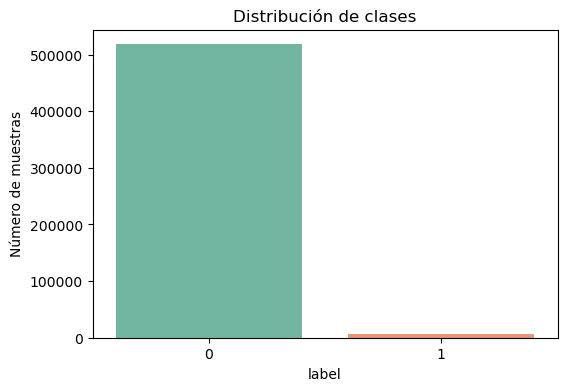

In [5]:
# Gráficamos la distribución
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette="Set2")
plt.title("Distribución de clases")
plt.ylabel("Número de muestras")
plt.show()


Despues de leer los datos y ver la distribución de la clase objetivo, se puede ver un fuerte desbalanceo, dominando la clase no phising por un gran margen. Lo cual, podría ser un problemas para algunas pruebas pero se tratará en el preprocesamiento.

Ahora procedermos a ver  más características de estos datos y comentarlos

In [59]:
# Resumen estadístico de las variables
df.describe()

,num_words,num_unique_words,num_stopwords,num_links,num_unique_domains,num_email_addresses,num_spelling_errors,num_urgent_keywords,label
count,5.248460e+05,524846.000000,524846.000000,524846.000000,524846.000000,524846.000000,524846.000000,524846.000000,524846.000000
mean,2.762280e+02,123.012167,80.045465,0.895588,0.347767,2.114897,24.694731,0.245301,0.013240
std,3.335457e+03,201.626478,1023.330380,5.603001,1.774209,13.592682,311.312358,0.559320,0.114301
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.700000e+01,38.000000,12.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
50%,1.200000e+02,79.000000,34.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000
75%,2.690000e+02,145.000000,79.000000,0.000000,0.000000,1.000000,22.000000,0.000000,0.000000
max,2.339682e+06,51251.000000,720411.000000,824.000000,524.000000,1150.000000,190104.000000,7.000000,1.000000


In [60]:
# Información general 
df.info()

# Resumen del mínimo, máximo y media de las variables
df.describe().T[['min','max','mean']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524846 entries, 0 to 524845
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   num_words            524846 non-null  int64
 1   num_unique_words     524846 non-null  int64
 2   num_stopwords        524846 non-null  int64
 3   num_links            524846 non-null  int64
 4   num_unique_domains   524846 non-null  int64
 5   num_email_addresses  524846 non-null  int64
 6   num_spelling_errors  524846 non-null  int64
 7   num_urgent_keywords  524846 non-null  int64
 8   label                524846 non-null  int64
dtypes: int64(9)
memory usage: 36.0 MB


,min,max,mean
num_words,0.0,2339682.0,276.228000
num_unique_words,0.0,51251.0,123.012167
num_stopwords,0.0,720411.0,80.045465
num_links,0.0,824.0,0.895588
num_unique_domains,0.0,524.0,0.347767
num_email_addresses,0.0,1150.0,2.114897
num_spelling_errors,0.0,190104.0,24.694731
num_urgent_keywords,0.0,7.0,0.245301
label,0.0,1.0,0.013240


In [61]:
# Comprobamos valores nulos en cada columna
df.isnull().sum()

num_words              0
num_unique_words       0
num_stopwords          0
num_links              0
num_unique_domains     0
num_email_addresses    0
num_spelling_errors    0
num_urgent_keywords    0
label                  0
dtype: int64

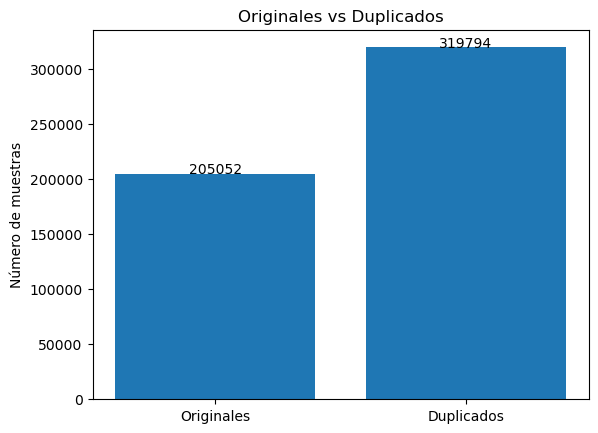

In [6]:
# Comprobamos el número de duplicados
duplicados = df.duplicated().sum()
total = len(df)
sin_duplicados = total - duplicados

# Preparamos los valores para graficar
valores = [sin_duplicados, duplicados]
categorias = ['Originales', 'Duplicados']

# Creamos un gráfico de barras comparando duplicados y originales
plt.bar(categorias, valores)
plt.title("Originales vs Duplicados")
plt.ylabel("Número de muestras")
plt.xlabel("")

# Mostrar valores encima de cada barra
for i, v in enumerate(valores):
    plt.text(i, v + 1, str(v), ha='center')

plt.show()



Tras todo esto podemos ver:
- Todas las variables son de tipo **int64**, por lo que no será necesario realizar conversiones adicionales para el entrenamiento.  
- No se detectan **valores nulos** en el dataset.  
- Existe un **alto número de registros duplicados** (más del 50% del total), lo que podría afectar negativamente el rendimiento de varios modelos.  
- También hay muchas variables que tienen medias bajas en comparación con sus máximos, lo que indica una distribución irregular y la posible presencia de **outliers** (ej. `num_spelling_errors` con media ~25 y máximo >190.000). 

# Preprocesamiento 

Tras la exploración inicial de los datos, se procederá a eliminar las entradas duplicadas del dataset, normalización/estandarización de las variables y aplicación de una técnica de oversampling para tratar de equilibrar el número de clases phising.

Número de duplicados después de limpiar: 0
Tamaño nuevo: (205052, 9)


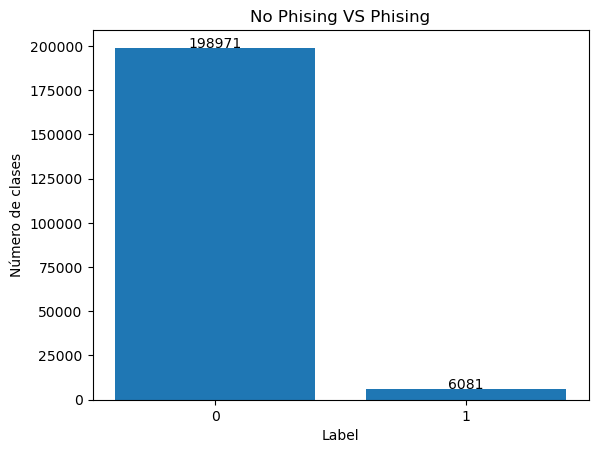

In [7]:
# Eliminación de duplicados
df_clean = df.drop_duplicates()

# Confirmamos que ya no queden duplicados
print("Número de duplicados después de limpiar:", df_clean.duplicated().sum())
print("Tamaño nuevo:", df_clean.shape)


# Visualización de la distribución de clases
categorias = df_clean['label'].value_counts().index.astype(str)   # ['0', '1']
valores = df_clean['label'].value_counts().values                 # cantidades

plt.bar(categorias, valores)
plt.title("No Phising VS Phising")
plt.ylabel("Número de clases")
plt.xlabel("Label")

# Mostrar el valor numérico encima de cada barra
for i, v in enumerate(valores):
    plt.text(i, v + 1, str(v), ha='center')

plt.show()

A pesar de haber eliminado más de la mitad de las entradas por duplicados, el dataset resultante aún conserva un volumen considerable (cerca de 200.000 registros).  
Esta cantidad es suficiente para entrenar los modelos, y además se verá incrementada posteriormente mediante la técnica de **oversampling (SMOTE)** para equilibrar las clases.

Ahora veremos la distribución de las variables

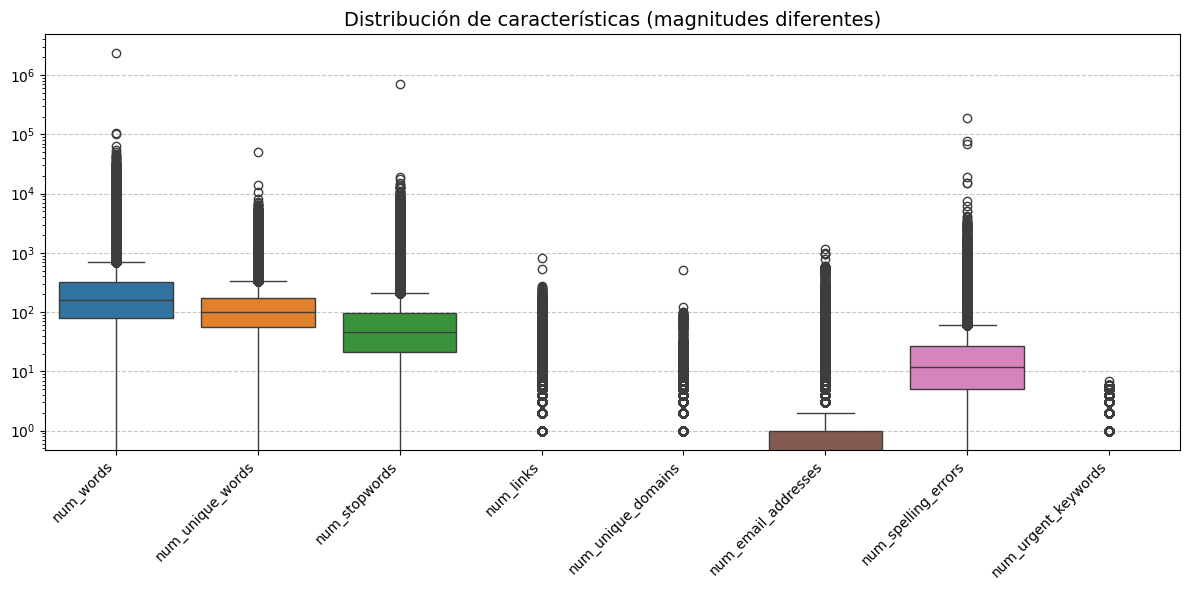

In [8]:
# Seleccionamos todas las columnas excepto la variable objetivo
features = [col for col in df_clean.columns if col != "label"]

# Gráfico de caja (boxplot) para todas las variables
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean[features])

# Ajustes de estilo
plt.title("Distribución de características (magnitudes diferentes)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yscale("log")  # Usamos escala logarítmica para visualizar mejor las diferencias de magnitud
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


El boxplot evidencia las **diferencias de escala** entre las variables.
- Algunas variables, como `num_words`, `num_unique_words`, `num_stopwords`, `num_spelling_errors` presentan valores muy superiores a su media.  
- Otras, como `num_links`, `num_unique_domains` o `num_email_addresses`, tienen valores bastante pequeños en comparación a los anteriores.  
- Se observa además una gran cantidad de **outliers** en la mayoría de las variables, especialmente en `num_spelling_errors` y `num_words`.

Con esta información podemos ver que variables necesitan mayor escalado que otras y se tendrán en cuenta para el escalado.



In [9]:
# Transformación y escalado de variables

# Definimos dos grupos de variables:
#  - features_log: variables con distribuciones más grandes y con valores extremos (colas largas)
#  - features_only_scale: variables con escalas más pequeñas pero que requieren estandarización
features_log = ['num_words','num_unique_words','num_stopwords','num_spelling_errors']
features_only_scale = ['num_links','num_unique_domains','num_email_addresses','num_urgent_keywords']

# Creamos una copia del conjunto de características
X = df_clean[features_log + features_only_scale].copy()

# Aplicamos la transformación logarítmica a las variables de mayor magnitud
for col in features_log:
    X[col] = np.log1p(X[col])

# Aplicamos un escalado estándar (media 0, desviación estándar 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertimos el resultado a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=features_log + features_only_scale)

# Variable objetivo (label)
y = df_clean["label"]




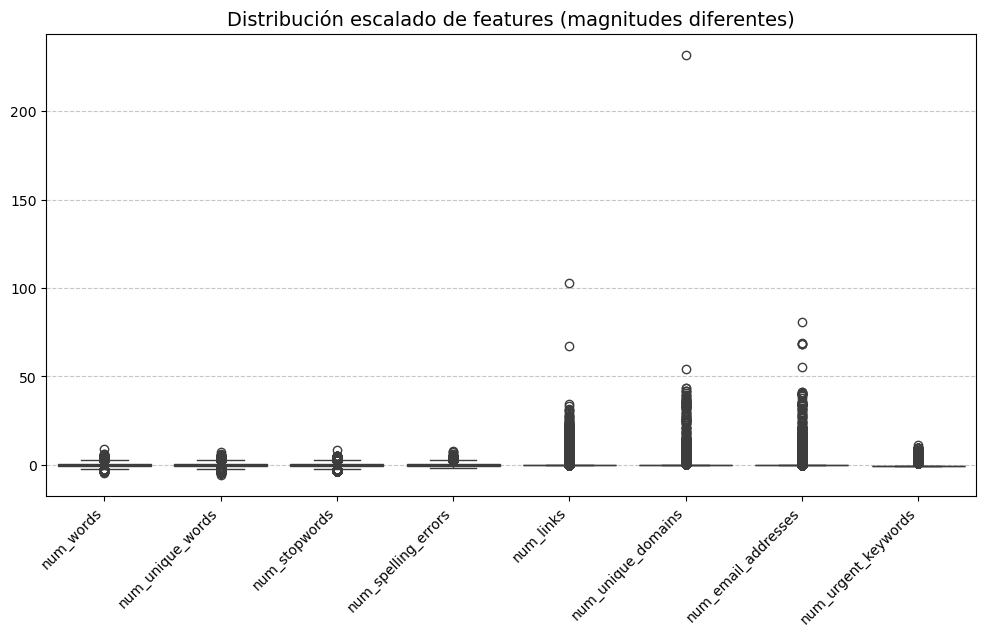

In [10]:
# Boxplot de las variables después del escalado estándar
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_scaled_df)

# Ajustes visuales
plt.title("Distribución escalado de features (magnitudes diferentes)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.show()


In [11]:
# Resumen estadístico después del escalado
X_scaled_df.describe()


,num_words,num_unique_words,num_stopwords,num_spelling_errors,num_links,num_unique_domains,num_email_addresses,num_urgent_keywords
count,2.050520e+05,2.050520e+05,2.050520e+05,2.050520e+05,2.050520e+05,2.050520e+05,2.050520e+05,2.050520e+05
mean,1.421955e-15,-6.044579e-16,9.392552e-16,7.698771e-17,-4.833930e-18,-8.602317e-18,-1.898920e-17,-4.792348e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-4.771236e+00,-5.521543e+00,-3.289626e+00,-2.086851e+00,-1.787802e-01,-2.112157e-01,-1.722294e-01,-4.921905e-01
25%,-6.881146e-01,-6.667945e-01,-6.417724e-01,-6.285977e-01,-1.787802e-01,-2.112157e-01,-1.722294e-01,-4.921905e-01
50%,-3.067303e-02,-1.550758e-02,8.493430e-03,6.756711e-04,-1.787802e-01,-2.112157e-01,-1.722294e-01,-4.921905e-01
75%,6.266265e-01,6.259348e-01,6.466527e-01,6.251189e-01,-1.787802e-01,-2.112157e-01,-1.017155e-01,-4.921905e-01
max,8.893930e+00,7.444374e+00,8.264124e+00,7.805967e+00,1.029207e+02,2.320032e+02,8.091878e+01,1.100657e+01


In [12]:
# Resumen del mínimo, máximo y media
X_scaled_df.describe().T[['min','max','mean']]

,min,max,mean
num_words,-4.771236,8.893930,1.421955e-15
num_unique_words,-5.521543,7.444374,-6.044579e-16
num_stopwords,-3.289626,8.264124,9.392552e-16
num_spelling_errors,-2.086851,7.805967,7.698771e-17
num_links,-0.178780,102.920683,-4.833930e-18
num_unique_domains,-0.211216,232.003186,-8.602317e-18
num_email_addresses,-0.172229,80.918775,-1.898920e-17
num_urgent_keywords,-0.492190,11.006572,-4.792348e-17


Después de aplicar la transformación logarítmica y el escalado estándar, las variables presentan medias cercanas a **0** y desviaciones estándar próximas a **1**, lo que significa que el escalado fuen un éxito.

En el boxplot, las distribuciones de las características ya aparecen acorde a esta normalización. Las grandes diferencias de magnitud observadas antes del escalado han desaparecido, aunque todavía se aprecian algunos valores atípicos (outliers), especialmente en las variables `num_links` y `num_unique_domains`. Estos valores extremos no afectan de manera significativa al conjunto de datos.

En conjunto, el siguiente paso sería hacer una partición de los datos y el oversampling.

# Split y  Oversampling

Ahora se procederá a relizar una parttición 80/20 de los datos escalados, junto a la técnica de sobremuestreo **Smote**, con el objetivo de mitigar el desbalanceo entre clases y mejorar la capacidad de generalización de los modelos.

In [14]:
# ====== 1) Split ======
X = X_scaled_df
y = df_clean["label"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ====== 2) SMOTE solo en TRAIN (30%) ======
print("Train antes:", Counter(y_train))
sm = SMOTE(sampling_strategy=0.3, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("Train después:", Counter(y_train_res))

Train antes: Counter({0: 159176, 1: 4865})
Train después: Counter({0: 159176, 1: 47752})


Con este resultado, se puede observar que el sobremuestreo fue logrado, rondado cerca del 30% en el set de entrenamiento.

In [15]:
# Comprobamos la distribución de clases en el conjunto de test
print("Test balance:", Counter(y_test))
print("Proporciones en test:")
display(pd.DataFrame({
    "Cantidad": y_test.value_counts().sort_index(),
    "Proporción (%)": (y_test.value_counts(normalize=True).sort_index() * 100).round(2)
}))


Test balance: Counter({0: 39795, 1: 1216})
Proporciones en test:


,Cantidad,Proporción (%)
label,,
0,39795,97.03
1,1216,2.97


Sin embargo, no lo aplicamos en el conjunto de test. El objetivo es que, durante la fase de evaluación, los modelos se enfrenten a un conjunto de datos con una distribución similar a la de un caso real, posiblemente muy desbalanceado.

Estos serán todos los conjuntos de entrenamiento y test que se usarán en las pruebas de los algoritmos de machine learning
    

# Entrenamiento de modelos

Antes de entrenar los modelos, se definen las funciones de evaluación y visualización de resultados.

In [13]:
def _get_proba(model, X):
    """Devuelve probas"""
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        return (s - s.min()) / (s.max() - s.min() + 1e-12)
    
    if hasattr(model, "predict"):
        proba = model.predict(X, verbose=0)
        return proba.ravel() if proba.ndim > 1 else proba
    raise ValueError("El modelo no expone predict_proba/decision_function/predict.")

def evaluar_modelo(model, X_test, y_test, nombre="Modelo", threshold=0.5, train_time=None):
    """Evalúa con matriz de confusión, F1_1, Recall_1, PR AUC."""
    y_proba = _get_proba(model, X_test)
    y_pred  = (y_proba >= threshold).astype(int)

    print(f"=== Evaluación de {nombre} (threshold={threshold}) ===")
    print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

    f1_pos  = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec_pos = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    pr_auc  = average_precision_score(y_test, y_proba)
    precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    acc = accuracy_score(y_test, y_pred)

    print(f"Precision global: {acc:.4f}")
    print(f"Precision (clase 1): {precision:.4f}")
    print(f"Recall    (clase 1): {rec_pos:.4f}")
    print(f"F1        (clase 1): {f1_pos:.4f}")
    print(f"PR AUC (Average Precision): {pr_auc:.4f}")

    # Mostrar tiempo de entrenamiento
    if train_time is not None:
        print(f"Tiempo de entrenamiento: {train_time:.4f} segundos \n")
    else:
        print(f"Tiempo de entrenamiento: no disponible\n")


def graficar_modelo(model, X_test, y_test, nombre="Modelo", threshold=0.5, train_time=None):
    """Confusion matrix + PR curve + barras de métricas en el umbral dado."""
    y_proba = _get_proba(model, X_test)
    y_pred  = (y_proba >= threshold).astype(int)

    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2], wspace=0.25, hspace=0.30)

    # 1) Matriz de confusión
    ax1 = fig.add_subplot(gs[0, 0])
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax1)
    ax1.set_title(f"Matriz de confusión — {nombre}")
    ax1.set_xlabel("Predicción"); ax1.set_ylabel("Real")

    # 2) Curva Precision–Recall
    ax2 = fig.add_subplot(gs[0, 1])
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    ax2.plot(rec, prec, linewidth=2, label=f"PR AUC = {ap:.3f}")
    ax2.set_title(f"Curva Precision–Recall — {nombre}")
    ax2.set_xlabel("Recall"); ax2.set_ylabel("Precision")
    ax2.legend(loc="lower left")

    # 3) Barras de métricas en el umbral elegido
    ax3 = fig.add_subplot(gs[1, :])
    p1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    r1 = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    acc= accuracy_score(y_test, y_pred)
    ax3.bar(["Precision_1","Recall_1","F1_1","Accuracy"], [p1, r1, f1, acc])
    ax3.set_ylim(0, 1)
    ax3.set_title(f"Métricas principales (threshold = {threshold}) — {nombre}")

    plt.tight_layout()
    plt.show()

    print(f"Threshold = {threshold}")
    print(f"Precision (clase 1): {p1:.4f}")
    print(f"Recall    (clase 1): {r1:.4f}")
    print(f"F1        (clase 1): {f1:.4f}")
    print(f"PR AUC (Average Precision): {ap:.4f}")
    print(f"Precision global: {acc:.4f}")

    # Mostrar tiempo de entrenamiento
    if train_time is not None:
        print(f"Tiempo de entrenamiento: {train_time:.4f} segundos \n")
    else:
        print(f"Tiempo de entrenamiento: no disponible\n")





## TabNet

## Experimento 1

In [31]:
# --- Reproducibilidad ---
np.random.seed(42)
torch.manual_seed(42)

# === 2) Validación REAL a partir de train (sin SMOTE) ===
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

# === 3) SMOTE SOLO en sub-train ===
print("Train antes:", Counter(y_tr))
sm = SMOTE(sampling_strategy=0.3, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)
print("Train después:", Counter(y_tr_res))

# === Convertir a NumPy con dtypes correctos ===
to_np32   = lambda X: (X.values if hasattr(X, "values") else X).astype(np.float32)
to_np64_1d= lambda y: (y.values if hasattr(y, "values") else y).astype(np.int64).ravel()

X_tr_res_np = to_np32(X_tr_res)
y_tr_res_np = to_np64_1d(y_tr_res)
X_val_np    = to_np32(X_val)
y_val_np    = to_np64_1d(y_val)

X_test_np = to_np32(X_test)
y_test_np = to_np64_1d(y_test)

# === 4) TabNet ===
tabnet1 = TabNetClassifier(
    n_d=32, n_a=32,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=1e-3, weight_decay=1e-4),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params=dict(mode="max", factor=0.5, patience=5),
    seed=42, verbose=1
)

start = time.time()
tabnet1.fit(
    X_tr_res_np, y_tr_res_np,
    eval_set=[(X_val_np, y_val_np)],   # <-- usar las versiones NumPy
    eval_name=["val"],
    eval_metric=["auc"],
    max_epochs=200,
    patience=20,
    batch_size=1024,
    virtual_batch_size=256,
    num_workers=0
)
train_time_TAB1 = time.time() - start

Train antes: Counter({0: 143258, 1: 4378})
Train después: Counter({0: 143258, 1: 42977})
epoch 0  | loss: 0.56018 | val_auc: 0.72154 |  0:02:23s
epoch 1  | loss: 0.49001 | val_auc: 0.74999 |  0:04:52s
epoch 2  | loss: 0.46143 | val_auc: 0.78636 |  0:06:36s
epoch 3  | loss: 0.45205 | val_auc: 0.7913  |  0:08:01s
epoch 4  | loss: 0.43737 | val_auc: 0.80906 |  0:09:34s
epoch 5  | loss: 0.42384 | val_auc: 0.81612 |  0:11:34s
epoch 6  | loss: 0.42076 | val_auc: 0.81768 |  0:14:03s
epoch 7  | loss: 0.41265 | val_auc: 0.82478 |  0:16:39s
epoch 8  | loss: 0.40985 | val_auc: 0.82593 |  0:18:57s
epoch 9  | loss: 0.40601 | val_auc: 0.82312 |  0:21:22s
epoch 10 | loss: 0.40239 | val_auc: 0.82388 |  0:23:44s
epoch 11 | loss: 0.39812 | val_auc: 0.83634 |  0:26:13s
epoch 12 | loss: 0.39674 | val_auc: 0.82542 |  0:28:28s
epoch 13 | loss: 0.39599 | val_auc: 0.83658 |  0:30:53s
epoch 14 | loss: 0.39278 | val_auc: 0.83387 |  0:32:55s
epoch 15 | loss: 0.39145 | val_auc: 0.83959 |  0:34:39s
epoch 16 | loss

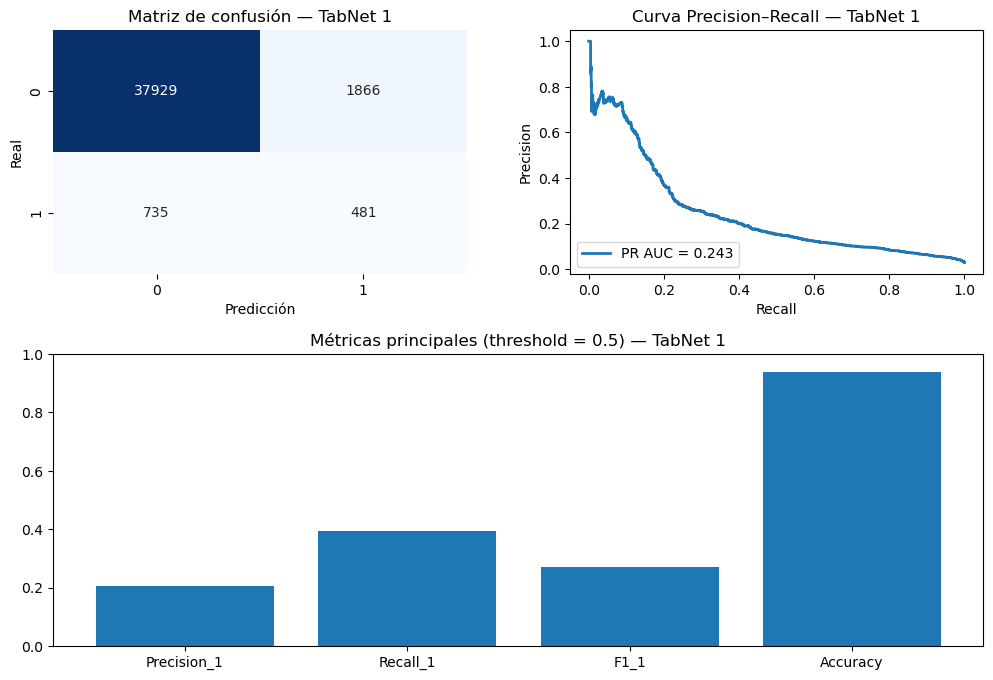

Threshold = 0.5
Precision (clase 1): 0.2049
Recall    (clase 1): 0.3956
F1        (clase 1): 0.2700
PR AUC (Average Precision): 0.2429
Precision global: 0.9366
Tiempo de entrenamiento: 9502.7414 segundos 



In [37]:
# Evaluamos en test
graficar_modelo(tabnet1, X_test_np, y_test_np, nombre="TabNet 1", threshold=0.5, train_time=train_time_TAB1)


## Experimento 2

In [34]:
# --- Reproducibilidad ---
np.random.seed(42)
torch.manual_seed(42)

# === 2) Validación REAL a partir de train (sin SMOTE) ===
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

# === 3) SMOTE SOLO en sub-train — MÁS BALANCE (0.4) ===
sm = SMOTE(sampling_strategy=0.4, random_state=42)    # <-- 0.3 → 0.4
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# === Convertir a NumPy (TabNet requiere np.float32 / np.int64) ===
to_np32    = lambda X: (X.values if hasattr(X, "values") else X).astype(np.float32)
to_np64_1d = lambda y: (y.values if hasattr(y, "values") else y).astype(np.int64).ravel()

X_tr_res_np = to_np32(X_tr_res);  y_tr_res_np = to_np64_1d(y_tr_res)
X_val_np    = to_np32(X_val);     y_val_np    = to_np64_1d(y_val)
X_test_np   = to_np32(X_test);    y_test_np   = to_np64_1d(y_test)

# === 4) TabNet — MÁS CAPACIDAD + MÁS REGULARIZACIÓN ===
tabnet2 = TabNetClassifier(
    n_d=64, n_a=64,                 # <-- 32 → 64
    n_steps=7,                      # <-- 5 → 7
    gamma=1.8,                      # <-- 1.5 → 1.8 (más diversidad)
    lambda_sparse=3e-4,             # <-- 1e-4 → 3e-4
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=5e-4, weight_decay=2e-4),  # <-- lr menor + WD mayor
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params=dict(mode="max", factor=0.5, patience=6),
    seed=42, verbose=1
    # device_name="cuda"  # si tienes GPU
)

start = time.time()
tabnet2.fit(
    X_tr_res_np, y_tr_res_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=["val"],
    eval_metric=["auc"],
    max_epochs=220,
    patience=25,                    # <-- 20 → 25
    batch_size=1024,
    virtual_batch_size=256,
    num_workers=0
)
train_time_TAB2 = time.time() - start


epoch 0  | loss: 0.67656 | val_auc: 0.69101 |  0:02:37s
epoch 1  | loss: 0.55177 | val_auc: 0.73136 |  0:05:24s
epoch 2  | loss: 0.53223 | val_auc: 0.7253  |  0:08:36s
epoch 3  | loss: 0.52396 | val_auc: 0.76103 |  0:11:27s
epoch 4  | loss: 0.51058 | val_auc: 0.74463 |  0:14:34s
epoch 5  | loss: 0.49453 | val_auc: 0.78482 |  0:17:26s
epoch 6  | loss: 0.48773 | val_auc: 0.79371 |  0:20:31s
epoch 7  | loss: 0.47796 | val_auc: 0.80967 |  0:23:25s
epoch 8  | loss: 0.47753 | val_auc: 0.80737 |  0:26:19s
epoch 9  | loss: 0.47447 | val_auc: 0.81536 |  0:29:06s
epoch 10 | loss: 0.46469 | val_auc: 0.8187  |  0:32:07s
epoch 11 | loss: 0.46343 | val_auc: 0.81094 |  0:34:57s
epoch 12 | loss: 0.4588  | val_auc: 0.82029 |  0:37:59s
epoch 13 | loss: 0.45235 | val_auc: 0.82707 |  0:40:58s
epoch 14 | loss: 0.45089 | val_auc: 0.82589 |  0:44:10s
epoch 15 | loss: 0.44814 | val_auc: 0.8335  |  0:47:01s
epoch 16 | loss: 0.44127 | val_auc: 0.82993 |  0:50:01s
epoch 17 | loss: 0.43827 | val_auc: 0.83571 |  0

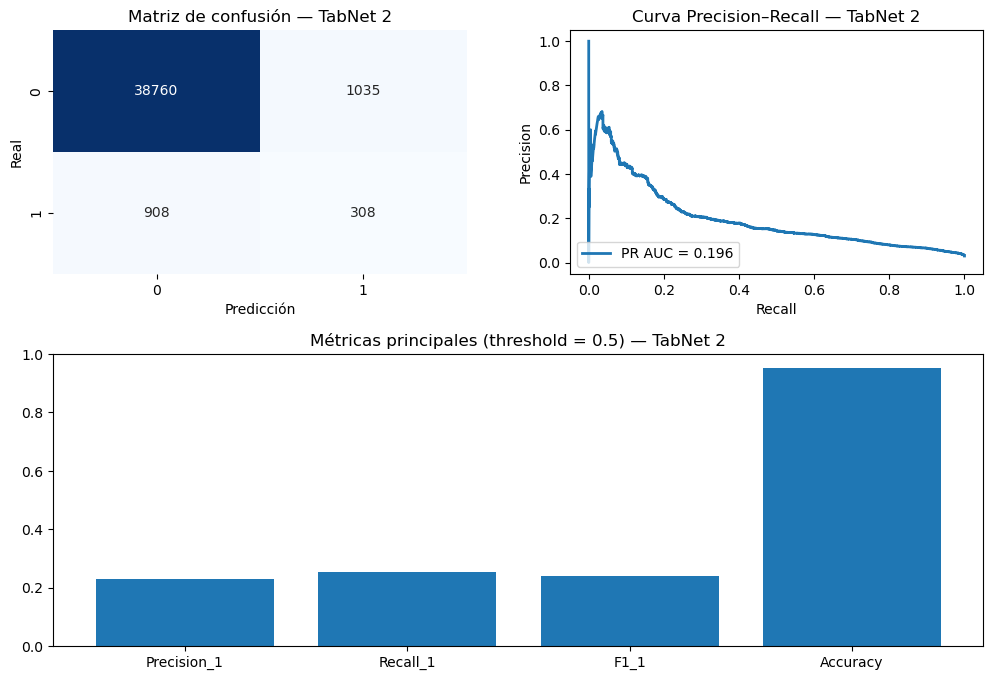

Threshold = 0.5
Precision (clase 1): 0.2293
Recall    (clase 1): 0.2533
F1        (clase 1): 0.2407
PR AUC (Average Precision): 0.1961
Precision global: 0.9526
Tiempo de entrenamiento: 28637.3537 segundos 



In [38]:
# Evaluamos en test
graficar_modelo(tabnet2, X_test_np, y_test_np, nombre="TabNet 2", threshold=0.5, train_time=train_time_TAB2)

## Experimento 3

In [39]:
# --- Reproducibilidad ---
np.random.seed(42)
torch.manual_seed(42)

# === 1) Split ya hecho: X_train, X_test, y_train, y_test ===

# === 2) Validación REAL a partir de train ===
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

# === 3) SMOTE SOLO en sub-train (equilibrado) ===
sm = SMOTE(sampling_strategy=0.3, random_state=42)   # <- moderado
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# === 4) Convertir a NumPy (TabNet requiere np.float32 / np.int64) ===
to_np32    = lambda X: (X.values if hasattr(X, "values") else X).astype(np.float32)
to_np64_1d = lambda y: (y.values if hasattr(y, "values") else y).astype(np.int64).ravel()

X_tr_res_np = to_np32(X_tr_res);  y_tr_res_np = to_np64_1d(y_tr_res)
X_val_np    = to_np32(X_val);     y_val_np    = to_np64_1d(y_val)
X_test_np   = to_np32(X_test);    y_test_np   = to_np64_1d(y_test)

# === 5) TabNet — capacidad intermedia + regularización moderada ===
tabnet3 = TabNetClassifier(
    n_d=48, n_a=48,               # <- intermedio (ni 32 ni 64)
    n_steps=6,                    # <- un poco más profundo que Exp1
    gamma=1.6,                    # <- diversificación moderada
    lambda_sparse=2e-4,           # <- regularización algo mayor que Exp1
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=7e-4, weight_decay=1e-4),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params=dict(mode="max", factor=0.5, patience=6),
    seed=42, verbose=1
)

start = time.time()
tabnet3.fit(
    X_tr_res_np, y_tr_res_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=["val"],
    eval_metric=["auc"],          # usamos ROC AUC para el scheduler/ES
    max_epochs=160,
    patience=20,
    batch_size=1024,
    virtual_batch_size=256,
    num_workers=0
)
train_time_TAB3 = time.time() - start



epoch 0  | loss: 0.89377 | val_auc: 0.64699 |  0:02:26s
epoch 1  | loss: 0.51057 | val_auc: 0.74387 |  0:04:41s
epoch 2  | loss: 0.47369 | val_auc: 0.79077 |  0:06:43s
epoch 3  | loss: 0.45548 | val_auc: 0.79068 |  0:08:36s
epoch 4  | loss: 0.44185 | val_auc: 0.79562 |  0:11:07s
epoch 5  | loss: 0.43171 | val_auc: 0.80704 |  0:13:49s
epoch 6  | loss: 0.42731 | val_auc: 0.80321 |  0:16:15s
epoch 7  | loss: 0.42442 | val_auc: 0.7914  |  0:18:51s
epoch 8  | loss: 0.42464 | val_auc: 0.81231 |  0:21:09s
epoch 9  | loss: 0.42087 | val_auc: 0.81149 |  0:23:26s
epoch 10 | loss: 0.41893 | val_auc: 0.81409 |  0:25:48s
epoch 11 | loss: 0.41611 | val_auc: 0.82202 |  0:27:55s
epoch 12 | loss: 0.41525 | val_auc: 0.80785 |  0:30:00s
epoch 13 | loss: 0.4118  | val_auc: 0.82148 |  0:32:02s
epoch 14 | loss: 0.40946 | val_auc: 0.83007 |  0:34:19s
epoch 15 | loss: 0.4051  | val_auc: 0.82338 |  0:36:41s
epoch 16 | loss: 0.40431 | val_auc: 0.82166 |  0:38:53s
epoch 17 | loss: 0.40364 | val_auc: 0.83508 |  0

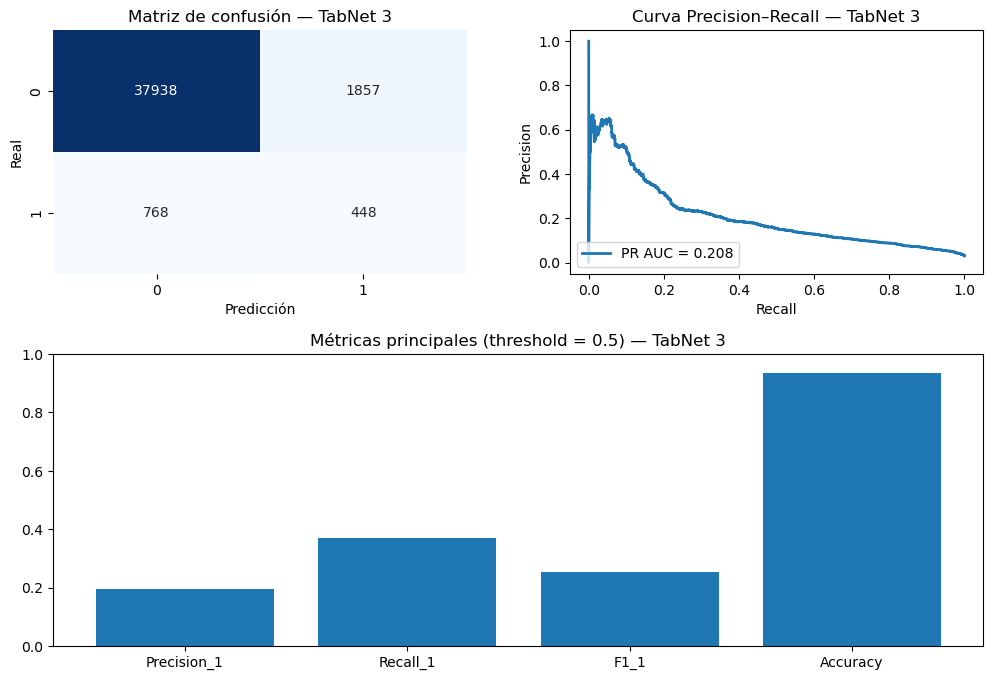

Threshold = 0.5
Precision (clase 1): 0.1944
Recall    (clase 1): 0.3684
F1        (clase 1): 0.2545
PR AUC (Average Precision): 0.2078
Precision global: 0.9360
Tiempo de entrenamiento: 19159.7397 segundos 



In [40]:
# Evaluamos en test
graficar_modelo(tabnet3, X_test_np, y_test_np, nombre="TabNet 3", threshold=0.5, train_time= train_time_TAB3)

## Experimento 4

In [42]:
# --- Reproducibilidad ---
np.random.seed(42)
torch.manual_seed(42)

# === 1) Split ya hecho: X_train, X_test, y_train, y_test ===

# === 2) Validación REAL a partir de train (SIN SMOTE) ===
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

# === 3) Pesos de clase en la loss (sin SMOTE) ===
cnt = Counter(y_tr)
w_pos = cnt[0] / max(cnt[1], 1)              # proporción neg/pos
class_weights = torch.tensor([1.0, w_pos], dtype=torch.float32)  # [neg, pos]

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)  # <-- CAMBIO CLAVE



# === 4) Convertir a NumPy (TabNet requiere np.float32 / np.int64) ===
to_np32    = lambda X: (X.values if hasattr(X, "values") else X).astype(np.float32)
to_np64_1d = lambda y: (y.values if hasattr(y, "values") else y).astype(np.int64).ravel()

X_tr_np  = to_np32(X_tr);   y_tr_np  = to_np64_1d(y_tr)
X_val_np = to_np32(X_val);  y_val_np = to_np64_1d(y_val)
X_test_np= to_np32(X_test); y_test_np= to_np64_1d(y_test)

# === 5) TabNet — más simple + entmax + class-weight ===
tabnet4 = TabNetClassifier(
    n_d=40, n_a=40,
    n_steps=5,
    gamma=1.6,
    lambda_sparse=2e-4,
    mask_type="entmax",
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=7e-4, weight_decay=1e-4),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params=dict(mode="max", factor=0.5, patience=6),
    seed=42, verbose=1
)

start = time.time()
tabnet4.fit(
    X_tr_np, y_tr_np,                      # y_tr_np int64 (0/1)
    eval_set=[(X_val_np, y_val_np)],
    eval_name=["val"],
    eval_metric=["auc"],
    loss_fn=loss_fn,                       # <-- ahora CE con pesos
    max_epochs=160,
    patience=20,
    batch_size=1024,
    virtual_batch_size=256,
    num_workers=0
)
train_time_TAB4 = time.time() - start




epoch 0  | loss: 0.87242 | val_auc: 0.64446 |  0:01:30s
epoch 1  | loss: 0.70066 | val_auc: 0.68312 |  0:02:58s
epoch 2  | loss: 0.66957 | val_auc: 0.73113 |  0:04:33s
epoch 3  | loss: 0.63589 | val_auc: 0.74287 |  0:06:04s
epoch 4  | loss: 0.60666 | val_auc: 0.7644  |  0:07:43s
epoch 5  | loss: 0.59343 | val_auc: 0.76221 |  0:09:25s
epoch 6  | loss: 0.59042 | val_auc: 0.78048 |  0:11:07s
epoch 7  | loss: 0.58597 | val_auc: 0.76208 |  0:12:36s
epoch 8  | loss: 0.57978 | val_auc: 0.769   |  0:14:11s
epoch 9  | loss: 0.57506 | val_auc: 0.78135 |  0:15:42s
epoch 10 | loss: 0.56712 | val_auc: 0.77872 |  0:17:10s
epoch 11 | loss: 0.5619  | val_auc: 0.78733 |  0:18:39s
epoch 12 | loss: 0.55059 | val_auc: 0.79878 |  0:20:06s
epoch 13 | loss: 0.54243 | val_auc: 0.78996 |  0:21:53s
epoch 14 | loss: 0.54347 | val_auc: 0.80105 |  0:23:28s
epoch 15 | loss: 0.54082 | val_auc: 0.79081 |  0:24:54s
epoch 16 | loss: 0.53445 | val_auc: 0.79452 |  0:26:30s
epoch 17 | loss: 0.53147 | val_auc: 0.79721 |  0

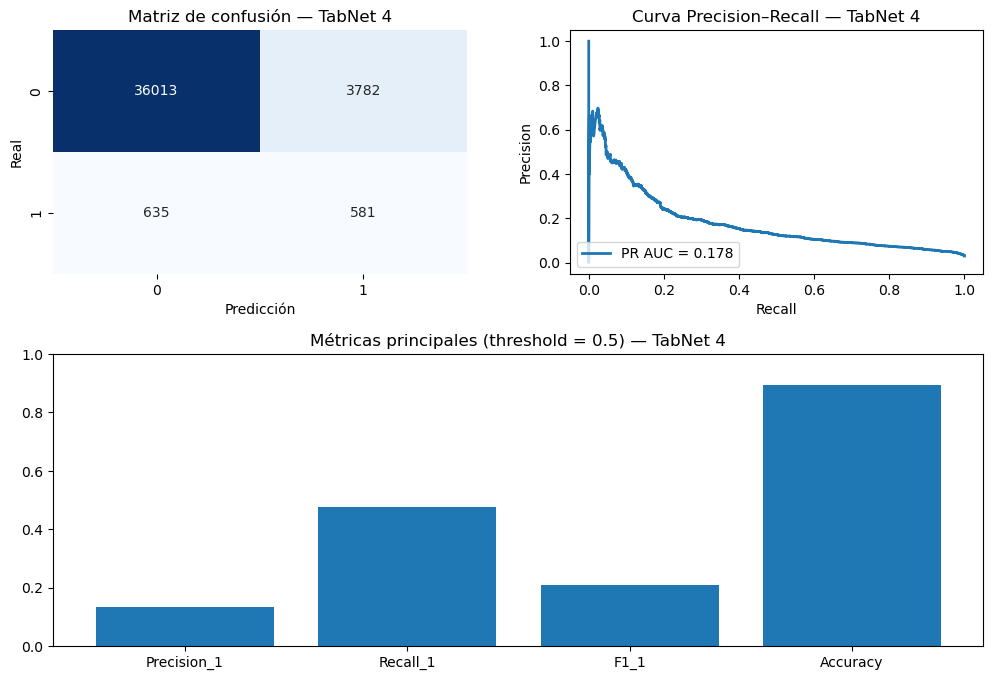

Threshold = 0.5
Precision (clase 1): 0.1332
Recall    (clase 1): 0.4778
F1        (clase 1): 0.2083
PR AUC (Average Precision): 0.1783
Precision global: 0.8923
Tiempo de entrenamiento: 5545.4966 segundos 



In [43]:
# Evaluamos en test
graficar_modelo(tabnet4, X_test_np, y_test_np, nombre="TabNet 4", threshold=0.5, train_time=train_time_TAB4)

## Experimento 5

In [44]:
# --- Reproducibilidad ---
np.random.seed(42)
torch.manual_seed(42)

# === 1) Split ya hecho: X_train, X_test, y_train, y_test ===
# === 2) Validación REAL (10%) ===
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.10, stratify=y_train, random_state=42
)

# === 3) SMOTE SOLO en sub-train (0.30) ===
sm = SMOTE(sampling_strategy=0.30, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# === 4) A NumPy (float32 / int64) ===
to_np32    = lambda X: (X.values if hasattr(X, "values") else X).astype(np.float32)
to_np64_1d = lambda y: (y.values if hasattr(y, "values") else y).astype(np.int64).ravel()
X_tr_res_np = to_np32(X_tr_res);  y_tr_res_np = to_np64_1d(y_tr_res)
X_val_np    = to_np32(X_val);     y_val_np    = to_np64_1d(y_val)
X_test_np   = to_np32(X_test);    y_test_np   = to_np64_1d(y_test)

# === 5) TabNet BASE (casi Exp1, con LR más bajo y algo más de sparsidad) ===
tabnet5 = TabNetClassifier(
    n_d=32, n_a=32,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=2e-4,      # ↑ vs Exp1
    mask_type="sparsemax",
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=5e-4, weight_decay=1e-4),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params=dict(mode="max", factor=0.5, patience=6),
    seed=42, verbose=1
)

start = time.time()
tabnet5.fit(
    X_tr_res_np, y_tr_res_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=["val"],
    eval_metric=["auc"],
    max_epochs=160,
    patience=18,
    batch_size=1024,
    virtual_batch_size=256,
    num_workers=0
)

train_time_TAB5 = time.time() - start



epoch 0  | loss: 0.59793 | val_auc: 0.67228 |  0:02:06s
epoch 1  | loss: 0.52135 | val_auc: 0.70039 |  0:04:15s
epoch 2  | loss: 0.49594 | val_auc: 0.73406 |  0:06:16s
epoch 3  | loss: 0.47603 | val_auc: 0.75692 |  0:08:48s
epoch 4  | loss: 0.46452 | val_auc: 0.76456 |  0:11:26s
epoch 5  | loss: 0.45755 | val_auc: 0.77458 |  0:14:07s
epoch 6  | loss: 0.44862 | val_auc: 0.78557 |  0:16:34s
epoch 7  | loss: 0.4381  | val_auc: 0.80153 |  0:18:24s
epoch 8  | loss: 0.4326  | val_auc: 0.80891 |  0:20:27s
epoch 9  | loss: 0.42754 | val_auc: 0.81689 |  0:22:19s
epoch 10 | loss: 0.42232 | val_auc: 0.81928 |  0:24:35s
epoch 11 | loss: 0.41901 | val_auc: 0.81989 |  0:26:35s
epoch 12 | loss: 0.41849 | val_auc: 0.82588 |  0:28:52s
epoch 13 | loss: 0.41257 | val_auc: 0.8276  |  0:30:56s
epoch 14 | loss: 0.41094 | val_auc: 0.8283  |  0:33:00s
epoch 15 | loss: 0.40949 | val_auc: 0.8273  |  0:35:13s
epoch 16 | loss: 0.40753 | val_auc: 0.83457 |  0:37:37s
epoch 17 | loss: 0.40496 | val_auc: 0.83928 |  0

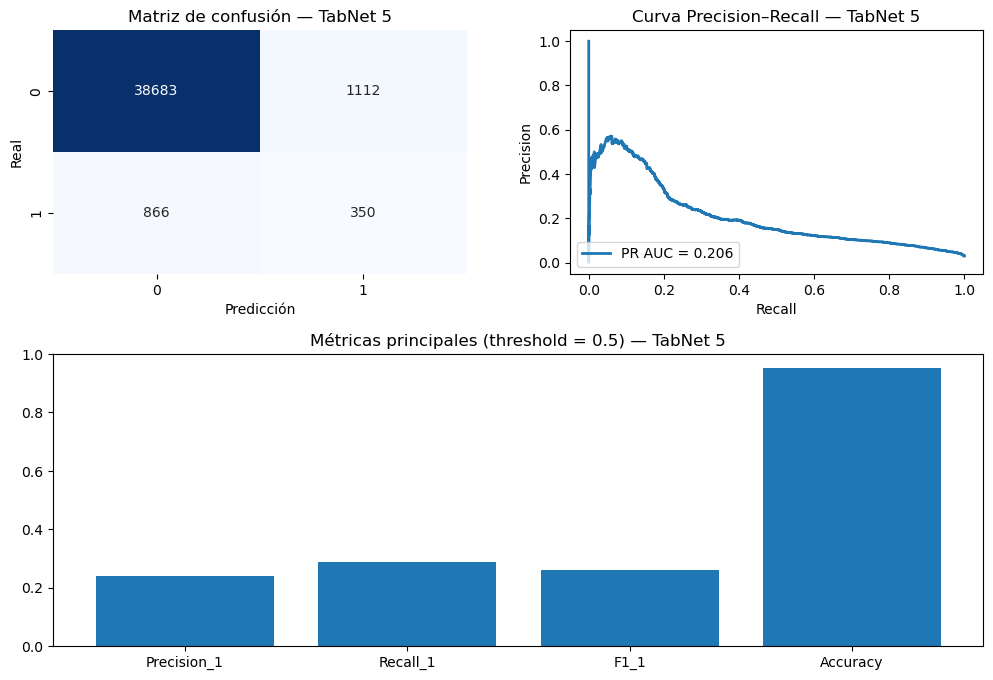

Threshold = 0.5
Precision (clase 1): 0.2394
Recall    (clase 1): 0.2878
F1        (clase 1): 0.2614
PR AUC (Average Precision): 0.2059
Precision global: 0.9518
Tiempo de entrenamiento: 10953.5405 segundos 



In [45]:
# Evaluamos en test
graficar_modelo(tabnet5, X_test_np, y_test_np, nombre="TabNet 5", threshold=0.5, train_time=train_time_TAB5)

## Experimento 6

In [46]:
# --- Reproducibilidad ---
np.random.seed(42)
torch.manual_seed(42)


# === validación real + SMOTE 0.30 ===
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

sm = SMOTE(sampling_strategy=0.30, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

to_np32    = lambda X: (X.values if hasattr(X, "values") else X).astype(np.float32)
to_np64_1d = lambda y: (y.values if hasattr(y, "values") else y).astype(np.int64).ravel()
X_tr_res_np = to_np32(X_tr_res); y_tr_res_np = to_np64_1d(y_tr_res)
X_val_np    = to_np32(X_val);    y_val_np    = to_np64_1d(y_val)
X_test_np   = to_np32(X_test);   y_test_np   = to_np64_1d(y_test)


tabnet6 = TabNetClassifier(
    n_d=32, n_a=32,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    mask_type="sparsemax",
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=5e-4, weight_decay=1e-4),  # ↓ LR
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params=dict(mode="max", factor=0.5, patience=6),
    seed=46, verbose=1
)

start = time.time()
tabnet6.fit(X_tr_res_np, 
            y_tr_res_np, 
            eval_set=[(X_val_np, y_val_np)], 
            eval_name=["val"], 
            eval_metric=["auc"],
            max_epochs=200, 
            patience=20, 
            batch_size=1024, 
            virtual_batch_size=256, 
            num_workers=0)

train_time_TAB6 = time.time() - start



epoch 0  | loss: 0.63549 | val_auc: 0.69372 |  0:02:26s
epoch 1  | loss: 0.51109 | val_auc: 0.73981 |  0:04:42s
epoch 2  | loss: 0.48401 | val_auc: 0.76608 |  0:07:24s
epoch 3  | loss: 0.46806 | val_auc: 0.77289 |  0:09:35s
epoch 4  | loss: 0.45859 | val_auc: 0.78211 |  0:11:42s
epoch 5  | loss: 0.44664 | val_auc: 0.78147 |  0:13:55s
epoch 6  | loss: 0.43918 | val_auc: 0.79711 |  0:15:54s
epoch 7  | loss: 0.43663 | val_auc: 0.80401 |  0:18:20s
epoch 8  | loss: 0.42855 | val_auc: 0.8     |  0:20:26s
epoch 9  | loss: 0.42116 | val_auc: 0.80726 |  0:22:33s
epoch 10 | loss: 0.4158  | val_auc: 0.80237 |  0:24:38s
epoch 11 | loss: 0.41354 | val_auc: 0.81247 |  0:26:42s
epoch 12 | loss: 0.40983 | val_auc: 0.81075 |  0:28:46s
epoch 13 | loss: 0.4072  | val_auc: 0.81228 |  0:31:05s
epoch 14 | loss: 0.40687 | val_auc: 0.81991 |  0:33:36s
epoch 15 | loss: 0.40376 | val_auc: 0.82301 |  0:36:01s
epoch 16 | loss: 0.40058 | val_auc: 0.81288 |  0:38:11s
epoch 17 | loss: 0.40079 | val_auc: 0.81732 |  0

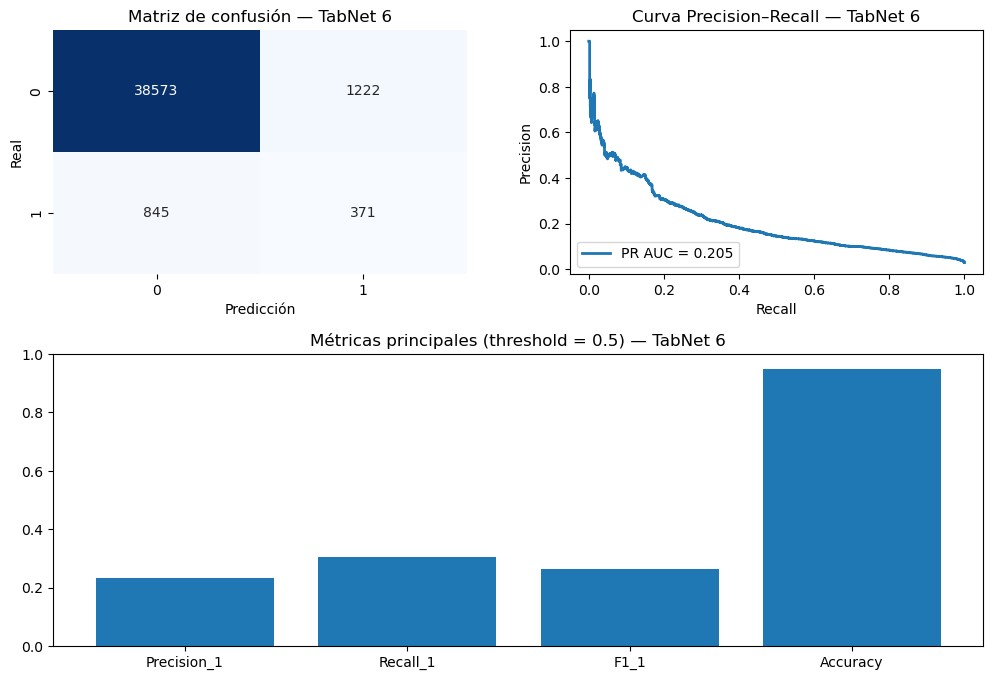

Threshold = 0.5
Precision (clase 1): 0.2329
Recall    (clase 1): 0.3051
F1        (clase 1): 0.2642
PR AUC (Average Precision): 0.2050
Precision global: 0.9496
Tiempo de entrenamiento: 9499.5694 segundos 



In [47]:
# Evaluamos en test
graficar_modelo(tabnet6, X_test_np, y_test_np, nombre="TabNet 6", threshold=0.5, train_time=train_time_TAB6)

## Experimento 7

In [48]:
# --- Reproducibilidad ---
np.random.seed(42)
torch.manual_seed(42)


# === validación real + SMOTE 0.30 ===
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

sm = SMOTE(sampling_strategy=0.30, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

to_np32    = lambda X: (X.values if hasattr(X, "values") else X).astype(np.float32)
to_np64_1d = lambda y: (y.values if hasattr(y, "values") else y).astype(np.int64).ravel()
X_tr_res_np = to_np32(X_tr_res); y_tr_res_np = to_np64_1d(y_tr_res)
X_val_np    = to_np32(X_val);    y_val_np    = to_np64_1d(y_val)
X_test_np   = to_np32(X_test);   y_test_np   = to_np64_1d(y_test)

start = time.time()
tabnet7 = TabNetClassifier(
    n_d=32, n_a=32,
    n_steps=6,                 # +1 paso
    gamma=1.5,
    lambda_sparse=1e-4,
    mask_type="sparsemax",
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=1e-3, weight_decay=1e-4),  # LR original
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params=dict(mode="max", factor=0.5, patience=6),
    seed=47, verbose=1
)
tabnet7.fit(X_tr_res_np, 
            y_tr_res_np, 
            eval_set=[(X_val_np, y_val_np)], 
            eval_name=["val"], 
            eval_metric=["auc"],
            max_epochs=200, 
            patience=20, 
            batch_size=1024, 
            virtual_batch_size=256, 
            num_workers=0)
train_time_TAB7 = time.time() - start




epoch 0  | loss: 0.67892 | val_auc: 0.7189  |  0:01:52s
epoch 1  | loss: 0.50501 | val_auc: 0.74993 |  0:03:38s
epoch 2  | loss: 0.48699 | val_auc: 0.75672 |  0:05:09s
epoch 3  | loss: 0.46761 | val_auc: 0.77839 |  0:06:44s
epoch 4  | loss: 0.45155 | val_auc: 0.7807  |  0:08:17s
epoch 5  | loss: 0.4408  | val_auc: 0.78825 |  0:09:52s
epoch 6  | loss: 0.43421 | val_auc: 0.80683 |  0:11:18s
epoch 7  | loss: 0.42426 | val_auc: 0.80678 |  0:12:51s
epoch 8  | loss: 0.41911 | val_auc: 0.82097 |  0:14:25s
epoch 9  | loss: 0.41392 | val_auc: 0.82247 |  0:15:59s
epoch 10 | loss: 0.41034 | val_auc: 0.81467 |  0:17:34s
epoch 11 | loss: 0.40476 | val_auc: 0.82542 |  0:19:08s
epoch 12 | loss: 0.40328 | val_auc: 0.81858 |  0:20:37s
epoch 13 | loss: 0.39977 | val_auc: 0.81474 |  0:22:11s
epoch 14 | loss: 0.39715 | val_auc: 0.81964 |  0:23:45s
epoch 15 | loss: 0.39791 | val_auc: 0.82667 |  0:25:20s
epoch 16 | loss: 0.39797 | val_auc: 0.82307 |  0:26:55s
epoch 17 | loss: 0.40011 | val_auc: 0.81055 |  0

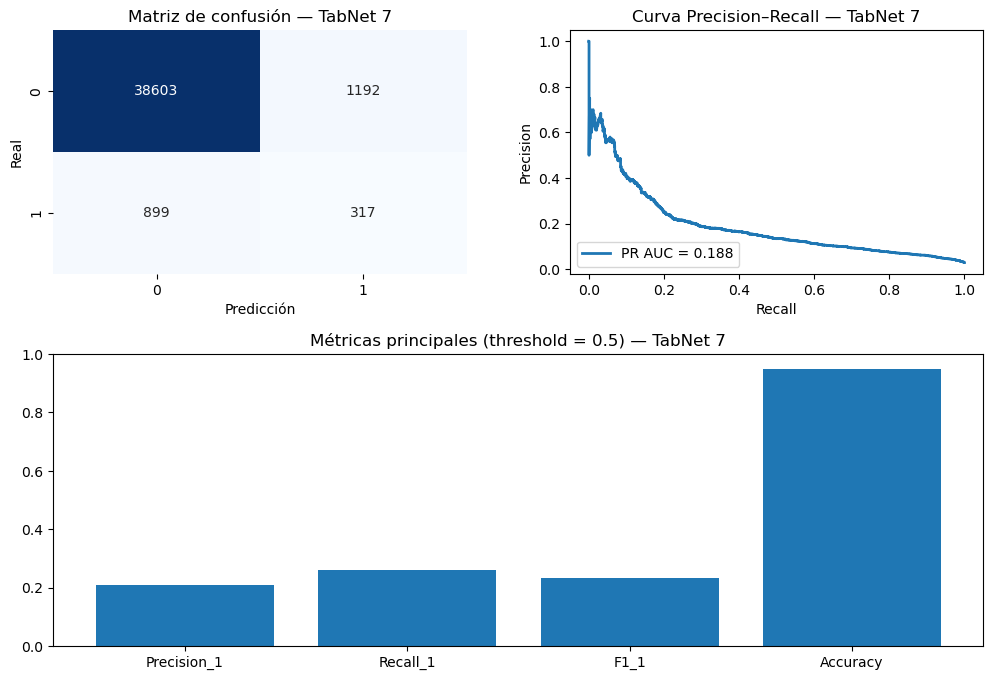

Threshold = 0.5
Precision (clase 1): 0.2101
Recall    (clase 1): 0.2607
F1        (clase 1): 0.2327
PR AUC (Average Precision): 0.1878
Precision global: 0.9490
Tiempo de entrenamiento: 5515.0496 segundos 



In [49]:
# Evaluamos en test
graficar_modelo(tabnet7, X_test_np, y_test_np, nombre="TabNet 7", threshold=0.5, train_time=train_time_TAB7)

## Experimento 8

In [50]:
# --- Reproducibilidad ---
np.random.seed(42)
torch.manual_seed(42)


# === validación real + SMOTE 0.30 ===
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

sm = SMOTE(sampling_strategy=0.30, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

to_np32    = lambda X: (X.values if hasattr(X, "values") else X).astype(np.float32)
to_np64_1d = lambda y: (y.values if hasattr(y, "values") else y).astype(np.int64).ravel()
X_tr_res_np = to_np32(X_tr_res); y_tr_res_np = to_np64_1d(y_tr_res)
X_val_np    = to_np32(X_val);    y_val_np    = to_np64_1d(y_val)
X_test_np   = to_np32(X_test);   y_test_np   = to_np64_1d(y_test)

tabnet8 = TabNetClassifier(
    n_d=48, n_a=48,            # ↑ capacidad
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    mask_type="sparsemax",
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=1e-3, weight_decay=1e-4),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params=dict(mode="max", factor=0.5, patience=6),
    seed=48, verbose=1
)

start = time.time()
tabnet8.fit(X_tr_res_np, 
            y_tr_res_np, 
            eval_set=[(X_val_np, y_val_np)], 
            eval_name=["val"], 
            eval_metric=["auc"],
            max_epochs=200, 
            patience=20, 
            batch_size=1024, 
            virtual_batch_size=256, 
            num_workers=0)
train_time_TAB8 = time.time() - start




epoch 0  | loss: 0.61859 | val_auc: 0.7395  |  0:01:24s
epoch 1  | loss: 0.48179 | val_auc: 0.7616  |  0:02:48s
epoch 2  | loss: 0.45268 | val_auc: 0.79799 |  0:04:10s
epoch 3  | loss: 0.43306 | val_auc: 0.79771 |  0:05:32s
epoch 4  | loss: 0.41887 | val_auc: 0.81514 |  0:06:56s
epoch 5  | loss: 0.40961 | val_auc: 0.8145  |  0:08:20s
epoch 6  | loss: 0.40823 | val_auc: 0.82329 |  0:09:48s
epoch 7  | loss: 0.40485 | val_auc: 0.82816 |  0:11:06s
epoch 8  | loss: 0.40083 | val_auc: 0.83161 |  0:12:31s
epoch 9  | loss: 0.39735 | val_auc: 0.8293  |  0:13:54s
epoch 10 | loss: 0.39409 | val_auc: 0.83473 |  0:15:46s
epoch 11 | loss: 0.38954 | val_auc: 0.83986 |  0:17:14s
epoch 12 | loss: 0.38679 | val_auc: 0.8374  |  0:18:30s
epoch 13 | loss: 0.38683 | val_auc: 0.83267 |  0:19:47s
epoch 14 | loss: 0.38503 | val_auc: 0.83642 |  0:21:28s
epoch 15 | loss: 0.382   | val_auc: 0.84351 |  0:23:30s
epoch 16 | loss: 0.37904 | val_auc: 0.84043 |  0:25:49s
epoch 17 | loss: 0.3781  | val_auc: 0.83128 |  0

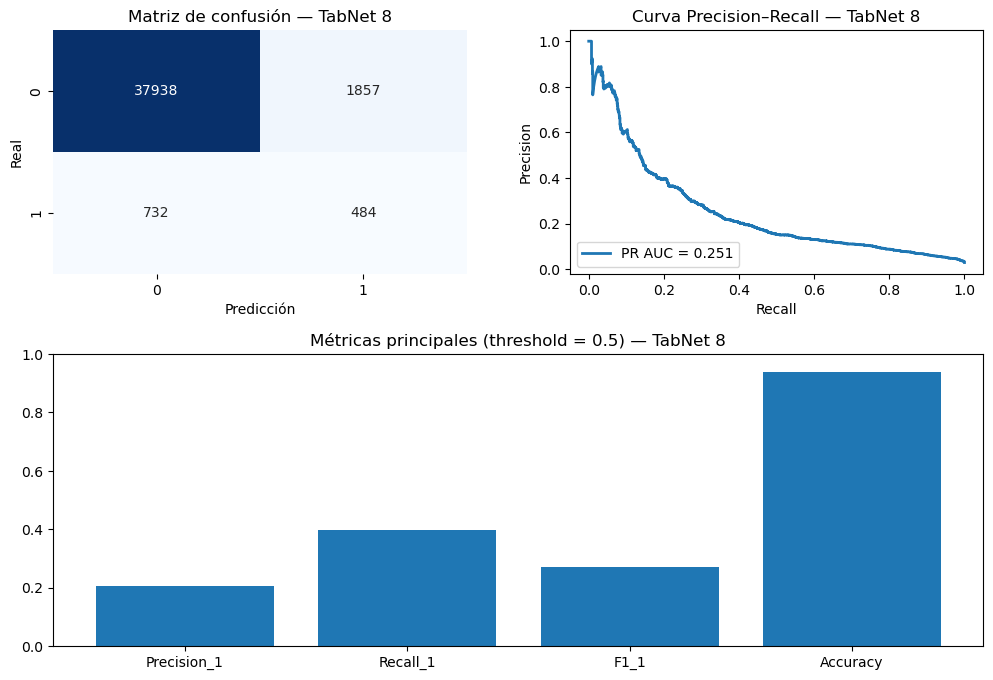

Threshold = 0.5
Precision (clase 1): 0.2067
Recall    (clase 1): 0.3980
F1        (clase 1): 0.2721
PR AUC (Average Precision): 0.2506
Precision global: 0.9369
Tiempo de entrenamiento: 10146.9062 segundos 



In [51]:
# Evaluamos en test
graficar_modelo(tabnet8, X_test_np, y_test_np, nombre="TabNet 8", threshold=0.5, train_time=train_time_TAB8)

## Experimento 9

In [52]:
# --- Reproducibilidad ---
np.random.seed(42)
torch.manual_seed(42)


# === validación real + SMOTE 0.30 ===
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

sm = SMOTE(sampling_strategy=0.30, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

to_np32    = lambda X: (X.values if hasattr(X, "values") else X).astype(np.float32)
to_np64_1d = lambda y: (y.values if hasattr(y, "values") else y).astype(np.int64).ravel()
X_tr_res_np = to_np32(X_tr_res); y_tr_res_np = to_np64_1d(y_tr_res)
X_val_np    = to_np32(X_val);    y_val_np    = to_np64_1d(y_val)
X_test_np   = to_np32(X_test);   y_test_np   = to_np64_1d(y_test)


tabnet9 = TabNetClassifier(
    n_d=32, n_a=32,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=3e-4,        # ↑ sparsidad
    mask_type="sparsemax",
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=1e-3, weight_decay=1e-4),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params=dict(mode="max", factor=0.5, patience=6),
    seed=49, verbose=1
)

start = time.time()
tabnet9.fit(X_tr_res_np, 
            y_tr_res_np, 
            eval_set=[(X_val_np, y_val_np)], 
            eval_name=["val"], 
            eval_metric=["auc"],
            max_epochs=200, 
            patience=20, 
            batch_size=1024, 
            virtual_batch_size=256, 
            num_workers=0)
train_time_TAB9 = time.time() - start




epoch 0  | loss: 0.60198 | val_auc: 0.72515 |  0:02:40s
epoch 1  | loss: 0.4849  | val_auc: 0.7708  |  0:05:30s
epoch 2  | loss: 0.45062 | val_auc: 0.79062 |  0:07:39s
epoch 3  | loss: 0.43241 | val_auc: 0.80353 |  0:09:11s
epoch 4  | loss: 0.42228 | val_auc: 0.81558 |  0:11:11s
epoch 5  | loss: 0.41726 | val_auc: 0.81104 |  0:12:26s
epoch 6  | loss: 0.41526 | val_auc: 0.82249 |  0:14:14s
epoch 7  | loss: 0.41137 | val_auc: 0.81975 |  0:16:07s
epoch 8  | loss: 0.40345 | val_auc: 0.82265 |  0:18:25s
epoch 9  | loss: 0.40008 | val_auc: 0.82779 |  0:20:09s
epoch 10 | loss: 0.3981  | val_auc: 0.82711 |  0:22:38s
epoch 11 | loss: 0.39707 | val_auc: 0.83065 |  0:24:41s
epoch 12 | loss: 0.39495 | val_auc: 0.83559 |  0:26:17s
epoch 13 | loss: 0.39235 | val_auc: 0.8326  |  0:28:09s
epoch 14 | loss: 0.39125 | val_auc: 0.83698 |  0:29:52s
epoch 15 | loss: 0.39054 | val_auc: 0.84024 |  0:31:41s
epoch 16 | loss: 0.38802 | val_auc: 0.83382 |  0:34:11s
epoch 17 | loss: 0.38662 | val_auc: 0.83039 |  0

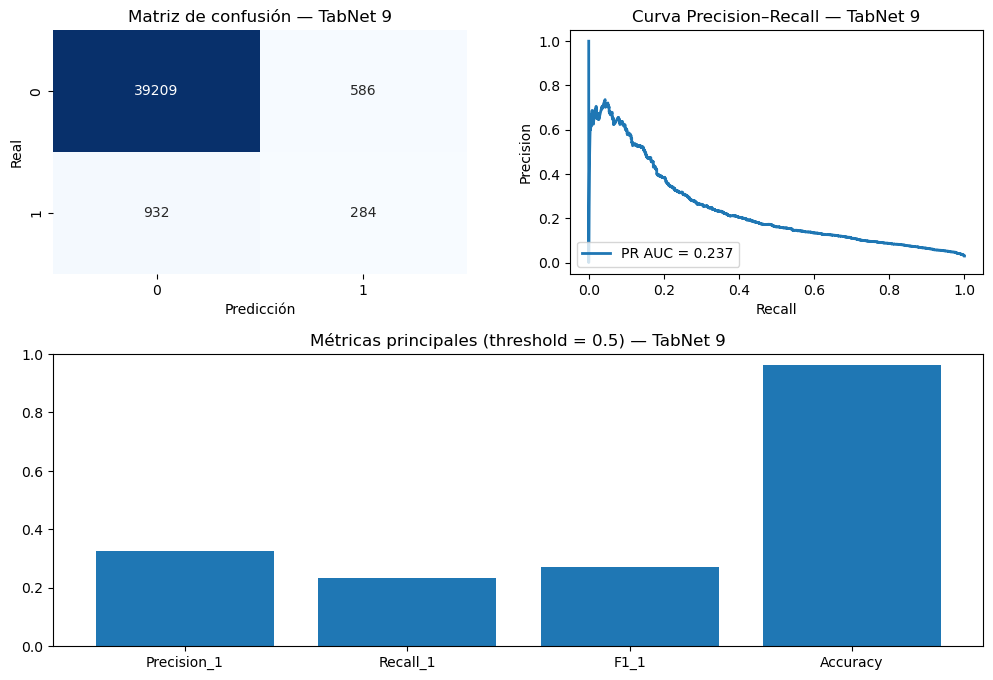

Threshold = 0.5
Precision (clase 1): 0.3264
Recall    (clase 1): 0.2336
F1        (clase 1): 0.2723
PR AUC (Average Precision): 0.2365
Precision global: 0.9630
Tiempo de entrenamiento: 15443.9792 segundos 



In [53]:
#Evaluamos en test
graficar_modelo(tabnet9, X_test_np, y_test_np, nombre="TabNet 9", threshold=0.5, train_time=train_time_TAB9)